# A Toxicology Experiment on the Death of Beetles
### by Diana Gerardo Fall 2018
## A Bayesian Approach

Continuation Part 2(b)

In [20]:
import numpy
import pandas
import math
import statsmodels.api as statmodels
import scipy.stats as scipy
import seaborn
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [21]:
dat = {'log_dose': [1.6907,1.7242,1.7552,1.7842,1.8113,1.8369,1.8610,1.8839], 
       'beetles': [59,60,62,56,63,59,62,60],
       'num_died': [6,13,18,28,52,53,61,60] }
beetles = pandas.DataFrame(data=dat)

**b)** Next, consider a binomial GLM with a logit link, i.e., now the $y_{i}$
are assumed independent, given $\beta_{1}$ and $\beta_{2}$, from
$\text{Bin}(m_{i},\pi(x_{i}))$, i = 1,...,8, where
$$\pi(x)\equiv\pi(x;\beta_{1},\beta_{2})=\frac{\exp\left(\beta_{1}+\beta_{2}x\right)}{\left\{ 1+\exp\left(\beta_{1}+\beta_{2}x\right)\right\} }$$
Working with a flat prior for $(\beta_{1},\beta_{2})$, obtain MCMC
samples from the posterior distributions for $\beta_{1}$, $\beta_{2}$,
and for $LD_{50}$, along with point and interval estimates for the
dose-response curve $\pi(x)$.

**Solution:**

In [22]:
logit_link= statmodels.families.links.logit()

response_variable = beetles['num_died']/beetles['beetles']
beetles['intercept'] = numpy.repeat(1, len(beetles))
covariates = beetles[['intercept','log_dose']]
weights = beetles['beetles']

In [23]:
logit_glm = statmodels.GLM(response_variable, covariates,
                             family = statmodels.families.Binomial(link = logit_link),
                             var_weights=numpy.asarray(weights))
logit_fitted = logit_glm.fit()

In [30]:
# Funcitons for M-H process

def burn_chain(burn, samples):
    T = burn
    samples = numpy.delete(samples, obj = range(0,T), axis = 1) 
    
    return samples

def flat_prior(x):
    '''flat prior'''
    return numpy.log(1)

def posterior(beta, x, y, m):
    exp_Xb = numpy.exp(beta[0]+beta[1]*x)
    bottom = 1 + exp_Xb
    log1 = numpy.log(exp_Xb/bottom)
    log2 = numpy.log(1 - (exp_Xb/bottom))
    inside_sum = y * log1 + (m - y) * log2
    
    values = numpy.exp( flat_prior(beta) + sum(inside_sum) ) 
        
    return values 

# This M_H_algorithm offers a flat beta prior with f_prior=True. 
# Set f_prior=False to set mean and sd for a normal prior. 
def M_H_algorithm(num_betas, iters, glm_fit, tune_para, y, x, w):
    burn = int(iters/4)
    iter_beta = numpy.zeros(shape=(num_betas, iters))
    new_beta = numpy.zeros(shape=(num_betas, iters))
    
    J = glm_fit.cov_params()
    d = tune_para   
    
    for i in range(1,iters):
        new_beta[:,i] = scipy.multivariate_normal.rvs(mean = iter_beta[:,i-1], cov = d*J, size = 1)
        numer = posterior(new_beta[:,i], x, y, w)
        denom = posterior(iter_beta[:,i-1], x, y, w)
        q = numpy.minimum(1, numer/denom )
        
        if numpy.random.uniform(0,1,1) < q:
            iter_beta[:,i] = new_beta[:,i]
        
        else:
            iter_beta[:,i] = iter_beta[:,i-1]
            
            
    return burn_chain(burn, iter_beta)

In [31]:
beta_samps = M_H_algorithm(num_betas = 2, iters = 10**4, glm_fit = logit_fitted, tune_para = 2,
                           y = beetles['num_died'], x = beetles['log_dose'], w = weights)

In [32]:
# plotting helpers

def convergence_plot(arr, color, title, xlab, ylab):
    for i in range(len(title)):
        plt.plot(arr[i,:], color = color)
        plt.title(title[i])
        plt.xlabel(xlab)
        plt.ylabel(ylab[i])
        plt.show()
        
def density_plot(arr, color, title, xlab):
    for i in range(len(title)):
        seaborn.kdeplot(arr[i,:], color = color, shade = True, lw = 1.5
                       ).set(ylabel='Density', xlabel = xlab[i], title = title[i])
        plt.show()


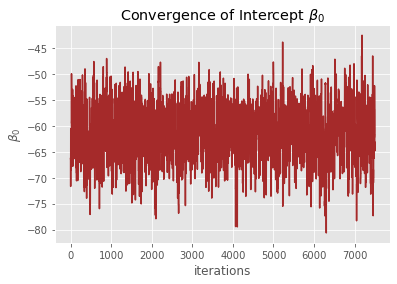

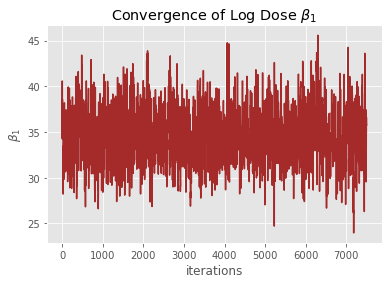

In [33]:
convergence_titles = ["Convergence of Intercept $\u03B2_{0}$", "Convergence of Log Dose $\u03B2_{1}$"]
ylabs = ["$\u03B2_{0}$","$\u03B2_{1}$"]
convergence_plot(beta_samps, "brown", convergence_titles, "iterations", ylabs)

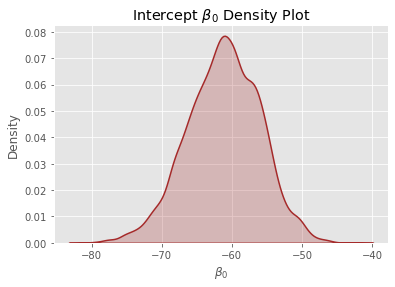

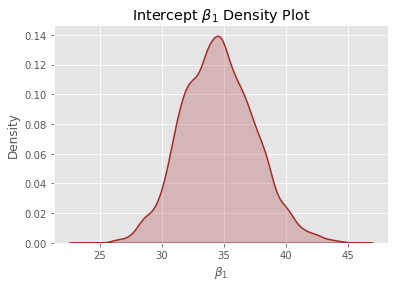

In [36]:
den_titles = ['Intercept $\u03B2_{0}$ Density Plot', 'Intercept $\u03B2_{1}$ Density Plot']
den_xlabs = ["$\u03B2_{0}$","$\u03B2_{1}$"]
density_plot(beta_samps, "brown", den_titles, den_xlabs)

In [39]:
# evaluating pi(x_i), cloglog function, for all x_grid

def logit_fucntion(x,b):
    Xb = b[0,:]+b[1,:]*x
    numer = numpy.exp(Xb)
    denom = 1 + numpy.exp(Xb)
    val = numer/denom
    
    return val 

def quantile_function(grid, betas, quantiles_to_compute):
    q = numpy.zeros(shape=(len(quantiles_to_compute), len(grid)))
    
    for i in range(100):
        new_pi = logit_fucntion(x_grid[i], betas)
        q[:,i] = numpy.quantile(new_pi, quantiles_to_compute)
    
    return q

In [40]:
x_grid = numpy.linspace(start=1.65, stop=1.9, num=100)
quants = [0.025,0.5,0.975]
conf_int = quantile_function(x_grid, beta_samps, quants) 

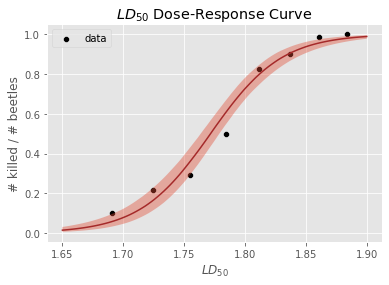

In [41]:
seaborn.lineplot(x = x_grid, y = conf_int[1,:], color = "brown")
seaborn.scatterplot(x = beetles["log_dose"], y = response_variable, color = "black", label = "data"
                   ).set(title = "$LD_{50}$ Dose-Response Curve", ylabel = "# killed / # beetles", xlabel = "$LD_{50}$")
plt.fill_between(x_grid,conf_int[2,:],conf_int[0,:], alpha = .4)